In [150]:
import Pkg
Pkg.add("AbstractTrees")
Pkg.add("PyCall")
Pkg.add("Conda")
Pkg.add("Measurements")
Pkg.add("DifferentialEquations")

# Intermediate Julia? + Some Fun

###  A brief outline:

    - Julia REPL: basic walkthrough.
    - Multiple Dispatch:
    - Macros: @assert
    - Julia is Fast.
    - Julia is Awesome at gluing things!
    - If we have time, some fused loops. 

# REPL: Your best friend

- Best REPL ever, in any language imo.
- 3 modes:
    - Shell
    - Package Manager
    - Help
- apropos()
- OhMyREPL.jl
- startup.jl
- double tabs for function definitions, autocomplete suggestions and whatnot.
- Emojis, if you didn't already know. you can clipboard them using `clipboard` :) 
- 1 C-q, @edit

# Multiple Dispatch + Type Inference: What makes Julia Julia.

## Recap of types.
- Julia has a type system, every value in Julia has a type
- Types are usually written in camelCase: AbstractString, Vector etc.
- There is a tree of types, called the type tree
- Each node other than the leaves are called `Abstract` Types, whereas the leaves are called `Concrete` Types. 

In [143]:
using AbstractTrees, BenchmarkTools, Plots, Conda, PyCall
AbstractTrees.children(x::Type) = subtypes(x)

In [5]:
print_tree(Number)

Number
├─ Complex
└─ Real
   ├─ AbstractFloat
   │  ├─ BigFloat
   │  ├─ Float16
   │  ├─ Float32
   │  └─ Float64
   ├─ AbstractIrrational
   │  └─ Irrational
   ├─ Integer
   │  ├─ Bool
   │  ├─ Signed
   │  │  ├─ BigInt
   │  │  ├─ Int128
   │  │  ├─ Int16
   │  │  ├─ Int32
   │  │  ├─ Int64
   │  │  └─ Int8
   │  └─ Unsigned
   │     ├─ UInt128
   │     ├─ UInt16
   │     ├─ UInt32
   │     ├─ UInt64
   │     └─ UInt8
   └─ Rational


# Type Inference:

Julia figures out which type is best suited for your variable, and makes do with that. This is helpful when you want to generate specialized code.
> _Quick version: you call a function, Julia will specialize that call all the way down to its concrete types. So you write f(x), then call f(1.0), it'll compile something specifically for Float64. If none of the types change in that function (called type-stability), then everything can be statically-typed, so Julia compiles a version of the function where everything is statically typed, and thus you get the speed of a statically-typed language after the first call which just compiles. So basically it is multiple dispatch, i.e. the ability to treat functions as different depending on the types that you call it with, that lets Julia compile statically-typed functions for each concrete type you throw in there. 
   ~ Chris Rackauckas_

# Multiple dispatch

Really intuitive concept. Infact you already know it. What do you do when you add 2 integers? 2 floats? 2 rational numbers? 2 strings? The operator that you use in your mind is the `+` sign, but the way through which you carry out the `+` operation is different for each of the types

Some handy definitions

    - function: the name of the "function / process" we are referring to.
    - method: what actually happens when we call the function with a specific combination of arguments.

Dispatch means that when a function call occurs, the language decides somehow which of the function methods have to be used.
No dispatch

## No Dispatch

In no dispatch, as in e.g. C, there is nothing to be decided. The method and the function are one and the same.
Single dispatch

## Single Dispatch  

In single dispatch, as in most object-oriented languages (like Python), it is possible for the same function name to have different methods. 

> Note: Show using Python REPL

```python
array.__len__(args...)  # usually written in python as len(array)
axis.__len__(args...) # len(axis)
```

where `array` could be an instance of something from `numpy` while `axis` could come from `matplotlib`. Here the language dispatches the function `len`, depending on the first argument, which is array or axis. It is important to note that in most object oriented languages, the method is a property of the type/class.  

## Multiple dispatch

Here dispatch occurs based on the type of every single function argument, as in

```julia
set_size(a::Array, args...) = ...
set_size(a::Axis, args...) = ...
set_size(s, a::Array, args...) = ...
set_size(a::Array, b::Vector) = ...
set_size(a::Array, x::Real, y::Real, z::Real) = ...
```  

This means that multiple dispatch allows for more exponentially more "expressive power", as one can use all arguments of the function to dispatch on.
How it works

Multiple dispatch follows easy-to-understand rules based on the Julia type system hierarchy.

Upon calling a function, Julia will try to find the method that is most specific across all arguments. This means that if a method is defined for both the Abstract type combination, as well as the concrete type combination, Julia will always call the more concrete one. This rule also applies to e.g. parametric types, since Vector{Float64} is more specialized than Vector. This rule also applies to unions, since Float64 is more specialized than Union{Float64, String}.

Two important points:

    - methods do not belong to the objects!
    - new methods can be defined after the types have been defined!


## Eg 1: Linear Algebra

$\sum_{i=1}^n v^T_iAv_i$  
$vs = \{v_i\} \forall i \in 1 \ldots n$ 

In [49]:
using LinearAlgebra

function inner_sum(A, vs)
    t = zero(eltype(A))
    for v in vs
        t += inner(v, A, v)
    end
    return t
end 

inner(v, A, w) = dot(v, A*w)

inner (generic function with 2 methods)

In [7]:
A = rand(3,3)
vs = [rand(3) for i in 1:5]
inner_sum(A, vs)

5.082048588049036

## A few Interesting things to notice:

- The `inner_sum` function is generic, in the sense that it will work for any datatype for which `dot` and `*` methods are defined.
- To write a generic algorithm, just leave out all the type annotations!(lol)
- Julia will decide which version of function to run on it's own.
- This makes it easier to extend julian code to accomodate new types of data.
- Lets illustrate this through the definition of a `OneHotVector`.

### OHV

- Vector with entry one at a particular index, and 0 in the rest of them. Why is it goos to make a separate type for this?

In [8]:
struct OHV <: AbstractVector{Bool} #Why the AbsVec??
    len::Int 
    ind::Int
end

I "know" that the necessary methods I need to extend to make OneHotVector truly behave like any arbitrary Julia vector
is
- a `size` method 
- a `getindex` method



In [9]:
# Extend size (so that it behaves like an array)
Base.size(v::OHV) = (v.len, )

# Extend indexing (so that accessing a OneHotVector like v[5] works)
Base.getindex(v::OHV, i::Integer) = i == v.ind

In [10]:
x = OHV(10, 3)

10-element OHV:
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0

In [11]:
vs = [OHV(3, rand(1:3)) for _ in 1:5]

5-element Vector{OHV}:
 [0, 1, 0]
 [0, 1, 0]
 [0, 0, 1]
 [1, 0, 0]
 [0, 0, 1]

In [12]:
inner_sum(A, vs) ##OP.

2.671605214928687

In [13]:
# More Efficient Version??
inner(w::OHV, a, v::OHV) = a[w.ind, v.ind] ##Faster shit.

inner (generic function with 2 methods)

# Macros and Expressions:

- Everyline of julia code starts as a string.
- It is converted into expressions once you parse them.Julia
- Expressions are tree awesome! you can manipulate them too!
- Macros do this exactly (at compile time, so that your code runs faster during runtime.)

<!--
## What happens when you run Julia Code??
![](./compilation_toolchain.png)
-->

In [14]:
x = "+(1, 2)"

"+(1, 2)"

In [15]:
ex = Meta.parse(x)

:(1 + 2)

In [16]:
fieldnames(typeof(ex)) # or ex.<TAB>

(:head, :args)

In [17]:
ex.head

:call

In [18]:
ex.args

3-element Vector{Any}:
  :+
 1
 2

In [19]:
x = "1 + 2*3^5"

"1 + 2*3^5"

In [20]:
ex = Meta.parse(x)

:(1 + 2 * 3 ^ 5)

In [21]:
ex.args

3-element Vector{Any}:
  :+
 1
  :(2 * 3 ^ 5)

In [22]:
ex.args[3] #Show further nesting.

:(2 * 3 ^ 5)

In [23]:
ex = :((x-1)*(x-2))

:((x - 1) * (x - 2))

In [24]:
ex2 = copy(ex)

:((x - 1) * (x - 2))

In [33]:
ex2.args[2].args[2] = :z

:z

In [34]:
ex2

:((z - 1) * (y - 2))

In [38]:
function replace_find(ex,find,replace) ## This is runtime replacement. What is runtime replacement?
    for (i, arg) in enumerate(ex.args)
        if arg == find
            ex.args[i] = replace
        end
        
        if isa(arg, Expr)
            replace_find(ex.args[i], find, replace)
        end
    end
end

replace_find (generic function with 1 method)

In [41]:
replace_find(ex2, :y, :z)

In [42]:
ex2

:((z - 1) * (z - 2))

In [45]:
# Lets create our own simple assert macro

macro assertif(ex)
    return :( $ex ? nothing : throw(AssertionError($(string(ex))))  )
end

@assertif (macro with 1 method)

In [48]:
@assertif 1==1

# Fun part starts!

## Yo Julia is fast as heck.

- type inference figures out types, multiple dispatch finds appropriate optimized functions. This is fast after the first run.
- Outline: Compare C, Python and Julia side by side on a simple `sum` function.

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [51]:
a = rand(10^7); # 1D vector of random numbers, uniform on [0,1)

In [52]:
sum(a)

4.9996633695853045e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [53]:
@time sum(a)

  0.012287 seconds (1 allocation: 16 bytes)


4.9996633695853045e6

In [54]:
@time sum(a)

  0.012295 seconds (1 allocation: 16 bytes)


4.9996633695853045e6

In [55]:
@time sum(a)

  0.012414 seconds (1 allocation: 16 bytes)


4.9996633695853045e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [57]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [58]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [59]:
c_sum(a)

4.999663369585541e6

In [60]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [61]:
c_sum(a) - sum(a)  

2.3655593395233154e-7

We can now benchmark the C code directly from Julia:

In [62]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     9.541 ms (0.00% GC)
  median time:      9.656 ms (0.00% GC)
  mean time:        9.745 ms (0.00% GC)
  maximum time:     12.371 ms (0.00% GC)
  --------------
  samples:          513
  evals/sample:     1

In [63]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.540698 msec


In [64]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.5407

In [159]:
using Plots
gr()

Plots.GRBackend()

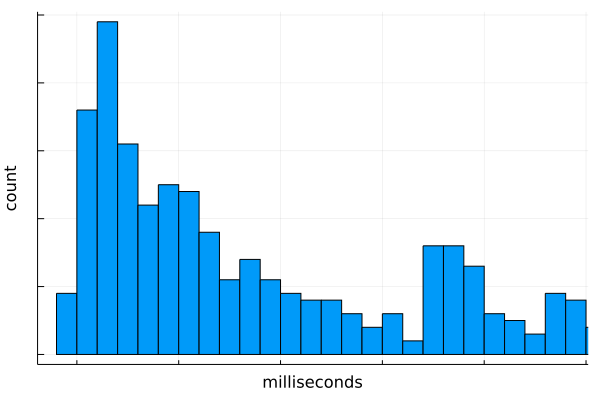

In [160]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [67]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [68]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.168 ms (0.00% GC)
  median time:      5.375 ms (0.00% GC)
  mean time:        5.434 ms (0.00% GC)
  maximum time:     8.767 ms (0.00% GC)
  --------------
  samples:          919
  evals/sample:     1

In [69]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

5.16818

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [82]:
# using Pkg; Pkg.add("PyCall")
using PyCall

In [83]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [84]:
pysum(a)

4.999663369585541e6

In [85]:
pysum(a) ≈ sum(a)

true

In [86]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     1.182 s (0.00% GC)
  median time:      1.188 s (0.00% GC)
  mean time:        1.212 s (0.00% GC)
  maximum time:     1.293 s (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

In [87]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.5407
  "Python built-in" => 1182.42
  "C -ffast-math"   => 5.16818

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [88]:
using Conda

In [90]:
 Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /home/learnedfool/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

# All requested packages already installed.



In [91]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     4.300 ms (0.00% GC)
  median time:      4.464 ms (0.00% GC)
  mean time:        4.577 ms (0.00% GC)
  maximum time:     8.604 ms (0.00% GC)
  --------------
  samples:          1091
  evals/sample:     1

In [92]:
numpy_sum(a)

4.999663369585307e6

In [93]:
numpy_sum(a) ≈ sum(a)

true

In [94]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 9.5407
  "Python numpy"    => 4.29981
  "Python built-in" => 1182.42
  "C -ffast-math"   => 5.16818

# 5. Python, hand-written 

In [95]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7ff380c04700>

In [96]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     1.488 s (0.00% GC)
  median time:      1.531 s (0.00% GC)
  mean time:        1.538 s (0.00% GC)
  maximum time:     1.601 s (0.00% GC)
  --------------
  samples:          4
  evals/sample:     1

In [97]:
sum_py(a)

4.999663369585541e6

In [98]:
sum_py(a) ≈ sum(a)

true

In [99]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.5407
  "Python numpy"        => 4.29981
  "Python hand-written" => 1488.37
  "Python built-in"     => 1182.42
  "C -ffast-math"       => 5.16818

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [100]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [101]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.095 ms (0.00% GC)
  median time:      4.322 ms (0.00% GC)
  mean time:        4.643 ms (0.00% GC)
  maximum time:     13.865 ms (0.00% GC)
  --------------
  samples:          1075
  evals/sample:     1

In [102]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.5407
  "Python numpy"        => 4.29981
  "Python hand-written" => 1488.37
  "Python built-in"     => 1182.42
  "Julia built-in"      => 4.09513
  "C -ffast-math"       => 5.16818

# 7. Julia (hand-written) 

In [103]:
function mysum(A)   
    s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [104]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  305.18 MiB
  allocs estimate:  20000000
  --------------
  minimum time:     239.702 ms (9.38% GC)
  median time:      251.229 ms (9.09% GC)
  mean time:        252.298 ms (10.73% GC)
  maximum time:     284.971 ms (9.65% GC)
  --------------
  samples:          20
  evals/sample:     1

In [105]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 9.5407
  "Python numpy"        => 4.29981
  "Julia hand-written"  => 239.702
  "Python hand-written" => 1488.37
  "Python built-in"     => 1182.42
  "Julia built-in"      => 4.09513
  "C -ffast-math"       => 5.16818

# Julia (hand written with inbounds)

In [108]:
function mysum_inbounds(A)   
    s = zero(eltype(A))
    @inbounds for a in A
        s += a
    end
    s
end

mysum_inbounds (generic function with 1 method)

In [109]:
j_bench_hand_inbounds = @benchmark mysum_inbounds($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     12.034 ms (0.00% GC)
  median time:      13.451 ms (0.00% GC)
  mean time:        13.605 ms (0.00% GC)
  maximum time:     24.436 ms (0.00% GC)
  --------------
  samples:          367
  evals/sample:     1

In [110]:
mysum_inbounds(a)

4.999663369585541e6

In [111]:
d["Julia hand-written inbounds"] = minimum(j_bench_hand_inbounds.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "C"                           => 9.5407
  "Python numpy"                => 4.29981
  "Julia hand-written"          => 239.702
  "Python hand-written"         => 1488.37
  "Python built-in"             => 1182.42
  "Julia built-in"              => 4.09513
  "C -ffast-math"               => 5.16818
  "Julia hand-written inbounds" => 12.0338

# 8. Julia (hand-written w. simd and inbounds) 

In [137]:
function mysum_simd(A)   
    s = zero(eltype(A))
    @inbounds @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [138]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     4.103 ms (0.00% GC)
  median time:      4.282 ms (0.00% GC)
  mean time:        4.692 ms (0.00% GC)
  maximum time:     12.846 ms (0.00% GC)
  --------------
  samples:          1063
  evals/sample:     1

In [139]:
mysum_simd(a)

4.999663369585311e6

In [140]:
d["Julia hand-written simd inbounds"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 9 entries:
  "C"                                => 9.5407
  "Python numpy"                     => 4.29981
  "Julia hand-written"               => 239.702
  "Python hand-written"              => 1488.37
  "Python built-in"                  => 1182.42
  "Julia built-in"                   => 4.09513
  "C -ffast-math"                    => 5.16818
  "Julia hand-written inbounds"      => 12.0338
  "Julia hand-written simd inbounds" => 4.10281

# Summary

In [141]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 40, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in.............................4.1
Julia hand-written simd inbounds...........4.1
Python numpy...............................4.3
C -ffast-math..............................5.2
C..........................................9.5
Julia hand-written inbounds...............12.0
Julia hand-written.......................239.7
Python built-in.........................1182.4
Python hand-written.....................1488.4


# Julia is awesome at gluing things.

- Multiple dispatch makes julia much more awesome at combining multiple packages, and it just works

## Outline:

- Measurements.jl
- Interoperability of Measurements with Plots
- Putting it all together with Differential Equation packages

In [8]:
using Measurements, Plots, DifferentialEquations
gr()

Plots.GRBackend()

In [9]:
a = 5 ± 0.1

5.0 ± 0.1

In [10]:
b = 6 ± 0.3

6.0 ± 0.3

In [11]:
@which a * b

*(a::Measurement, b::Measurement) in Measurements at /home/learnedfool/.julia/packages/Measurements/4OZKq/src/math.jl:187

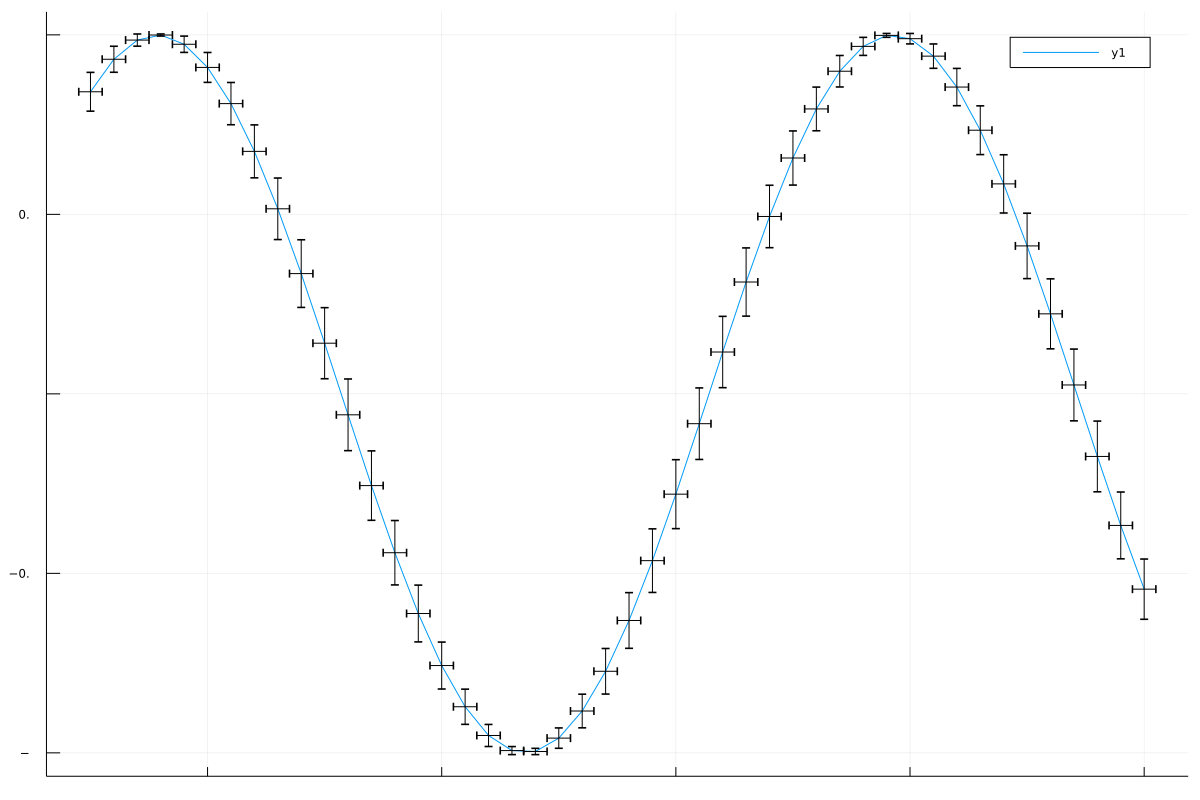

In [12]:
plot(sin, [x ± 0.1 for x in 1:0.2:10], size = (1200, 800))

# How do we bring in Differential equations in this?

## Consider the example of simulating a pendulum

The differential equation we want to solve is(this is true for small $\theta$)

$$\ddot{\theta} + \frac{g}{L} \theta = 0$$

where $g = (9.79 \pm 0.02)~\mathrm{m}/\mathrm{s}^2$ is the gravitational acceleration measured where the experiment is carried out, and $L = (1.00 \pm 0.01)~\mathrm{m}$ is the length of the pendulum.

## How is a differential equation solved using a computer?

Say you have an equation, 

$$\frac{du(t)}{dt} = f(u, p, t)$$

where $p$ is the set of parameters for the equation (Eg, decay constant in radioactive decay), $t$ is time, $u$ is the variable, (or vector) of variables that we are interested in monitoring. We would also have a set of initial beginning values, $u_0$ 

The computer basically discretizes the time steps and converts this fancy equation above into the following:

$$du(t) = f(u, p, t)dt$$

now $du = u_{n+1}-u_{n}$, and the equation becomes,

$$u_{n+1} = u_{n} + f(u, p, t)\Delta t$$

The computer takes in $u_0$, uses it to generate $u_1, u_2 \ldots u_n$.

You then plot it, and voila, you get the corresponding $u(t)$

## Back to the pendulum

Notice that the above example we took only deals with the first derivative, and not more than that; So we come up with a way to split the equation into 2 parts as follows

$$\frac{d\theta(t)}{dt} = \omega(t) $$, and
$$\frac{d^2\theta(t)}{dt^2} = \frac{d\omega(t)}{dt} = -\frac{g}{L}\theta(t)$$

So you will provide the derivatives of $\theta$ and $\omega$ to the program, it takes care of the rest!

In [13]:
# Lets try and simulate the movement of a pendulum!

g = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum

In [14]:
#Initial Conditions
u₀ = [0 ± 0, π / 60 ± 0.01] # Initial speed and initial angle
tspan = (0.0, 6.3)

(0.0, 6.3)

In [15]:
#Define the problem
function pendulum(du,u,p,t) #u is vector we wanna track, du is derivates, p is parameters
    θ  = u[1]  
    ω = u[2] 
    du[1] = dθ = ω   # differential wrt θ
    du[2] = dω = -(g/L)*θ  # differential wrt ω
end


pendulum (generic function with 1 method)

In [16]:
#Pass to solvers
prob = ODEProblem(pendulum, u₀, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-6);

In [17]:
# Analytic solution
u = u₀[2] .* cos.(sqrt(g / L) .* sol.t)

68-element Vector{Measurement{Float64}}:
    0.052 ± 0.01
    0.051 ± 0.0097
   0.0487 ± 0.0093
   0.0444 ± 0.0085
   0.0384 ± 0.0073
   0.0304 ± 0.0058
   0.0208 ± 0.004
   0.0097 ± 0.0019
 -0.00233 ± 0.00062
  -0.0146 ± 0.0028
  -0.0264 ± 0.0051
  -0.0368 ± 0.007
  -0.0451 ± 0.0086
          ⋮
  -0.0431 ± 0.0086
   -0.031 ± 0.0069
  -0.0159 ± 0.0053
   0.0006 ± 0.0046
   0.0169 ± 0.0055
   0.0315 ± 0.0071
   0.0429 ± 0.0087
   0.0501 ± 0.0097
   0.0523 ± 0.01
   0.0493 ± 0.0096
   0.0409 ± 0.0085
   0.0341 ± 0.0076

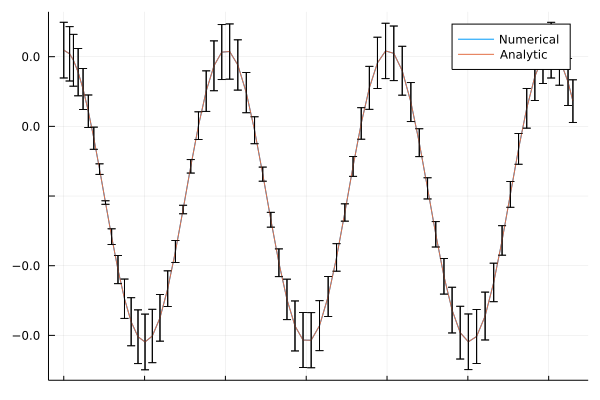

In [18]:
plot(sol.t, getindex.(sol.u, 2), label = "Numerical")
plot!(sol.t, u, label = "Analytic")

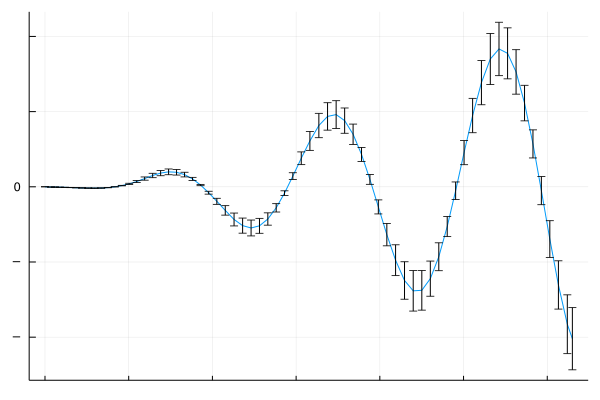

In [19]:
plot(sol.t, getindex.(sol.u, 2) .- u, label = "")